### **Descarga e importe de bibliotecas**

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

In [2]:
import gc
import re
import glob
import random
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras as keras
from tf_keras import Model
from tf_keras.models import load_model

2025-04-12 21:00:08.382085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744491608.655257      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744491608.730117      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Configuración del entorno**

In [3]:
# Set a seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### **Descarga y cargado de la base de datos de mamitas**

##### **Importante definir el número de clases**

In [4]:
classes = 2 # Son dos clases; 0-Fondo, 1-feet

In [5]:
config = {"Seg_model":"ResUNet","Activation":"softmax","Input size":(512,512,3),"Image size":(512,512),
          "Dataset":"mamitas-only-subject","Dir of dataset":"/kaggle/input/mamitas-only-subject","Batch size":32,"Number of classes":classes}

In [6]:
class DataLoader:

    def __init__(self, data_dir, batch_size, image_size, num_classes, partition):

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.partition = partition

    def load_images(self):

        # Create the path for patch images
        images_path_pattern = os.path.join(self.data_dir, self.partition, 'images', '*.png')
        images_files = glob.glob(images_path_pattern)

        # Sort patch files alphanumerically
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers for proper sorting
            return [int(part) if part.isdigit() else part for part in parts]

        images_files = sorted(images_files, key=alphanumeric_key)

        self.file_sample = []
        for file in images_files:
            name_file = file.split('/')[-1]
            self.file_sample.append(name_file)

        self.num_samples = len(images_files)

        # Print the complete path and the number of found patch images
        print(f"Complete images: {images_path_pattern}")
        print(f"Number of images files found: {len(images_files)}")

        # Create a TensorFlow dataset from the images file paths
        images_ds = tf.data.Dataset.from_tensor_slices(images_files)

        # Map each file path to a processed image
        images_ds = images_ds.map(self.process_images, num_parallel_calls=tf.data.AUTOTUNE)

        return images_ds

    def load_masks(self):

        mask_path_main = os.path.join(self.data_dir, self.partition, 'masks')

        # Check samples in classes
        for class_id in range(self.num_classes):
            mask_path_pattern = os.path.join(mask_path_main, f'class_{class_id}', '*.png')
            found_masks = glob.glob(mask_path_pattern)
            print(f"Original masks path, class {class_id}: {mask_path_pattern}")
            print(f"Number of masks found: {len(found_masks)}")

        masks_path = []
        # Organize ground truth masks by sample and class
        for sample in self.file_sample:
            masks_sample = []
            for class_id in range(self.num_classes):
                masks_sample.append(os.path.join(mask_path_main, f'class_{class_id}', sample))
            masks_path.append(masks_sample)

        # Create dataset from `masks_path` and apply `process_masks` to each set of paths
        masks_ds = tf.data.Dataset.from_tensor_slices(masks_path)
        masks_ds = masks_ds.map(self.process_masks, num_parallel_calls=tf.data.AUTOTUNE)

        return masks_ds

    def process_images(self, file_path):

        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_png(img, channels=3)  # Decode PNG image
        img = tf.image.resize(img, self.image_size)  # Resize image
        img = tf.cast(img, tf.float32)  # Convert to float32
        img /= 255.0  # Normalize to [0, 1]
        return img

    def process_masks(self, sample_paths):

        # Decode and process images
        decoded_images = tf.map_fn(
            tf.io.read_file,
            sample_paths,
            dtype=tf.string,
            parallel_iterations=4
        )

        masks = tf.map_fn(
            lambda x: tf.io.decode_png(x, channels=1),
            decoded_images,
            dtype=tf.uint8,
            parallel_iterations=4
        )

        # Resize and normalize
        masks = tf.map_fn(
            lambda x: tf.image.resize(x, size=self.image_size),
            masks,
            dtype=tf.float32
        )

        masks = tf.cast(masks, tf.float32)  # Convert to float32
        masks = masks / 255.0  # Normalize to [0, 1]
        masks = tf.squeeze(masks, axis=-1)  # Remove the last dimension
        masks = tf.transpose(masks, perm=[1, 2, 0])  # Transpose to [height, width, classes]

        return masks

    def get_dataset(self):

        images_ds = self.load_images()
        masks_ds = self.load_masks()
        dataset = tf.data.Dataset.zip((images_ds,masks_ds))

        # Apply batching and prefetching for optimization
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [7]:
# Instantiate data loader and load train partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Train')
train_dataset = data_loader.get_dataset()

Complete images: /kaggle/input/mamitas-only-subject/Train/images/*.png
Number of images files found: 342


2025-04-12 21:00:36.256671: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Original masks path, class 0: /kaggle/input/mamitas-only-subject/Train/masks/class_0/*.png
Number of masks found: 342
Original masks path, class 1: /kaggle/input/mamitas-only-subject/Train/masks/class_1/*.png
Number of masks found: 342


In [8]:
# Instantiate data loader and load validation partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Valid')
valid_dataset = data_loader.get_dataset()

Complete images: /kaggle/input/mamitas-only-subject/Valid/images/*.png
Number of images files found: 37
Original masks path, class 0: /kaggle/input/mamitas-only-subject/Valid/masks/class_0/*.png
Number of masks found: 37
Original masks path, class 1: /kaggle/input/mamitas-only-subject/Valid/masks/class_1/*.png
Number of masks found: 37


In [9]:
# Instantiate data loader and load test partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Test')
test_dataset = data_loader.get_dataset()

Complete images: /kaggle/input/mamitas-only-subject/Test/images/*.png
Number of images files found: 37
Original masks path, class 0: /kaggle/input/mamitas-only-subject/Test/masks/class_0/*.png
Number of masks found: 37
Original masks path, class 1: /kaggle/input/mamitas-only-subject/Test/masks/class_1/*.png
Number of masks found: 37


In [17]:
from functools import partial
from tf_keras.layers import Layer
from tf_keras import layers, Model
from tf_keras.saving import register_keras_serializable
from tf_keras.losses import Loss
# Definition of layers for the neural network structure

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)


upsample = partial(layers.UpSampling2D, (2,2))

@register_keras_serializable(package="my_custom_losses")
class DiceCoefficient(Loss):
    def __init__(self, smooth=1., target_class= None, name='DiceCoefficient', **kwargs):
        self.smooth = smooth
        self.target_class = target_class
        super().__init__(name=name,**kwargs)

    def call(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)
        
        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

@register_keras_serializable(package="my_custom_metrics")
def dice_metric(y_true, y_pred, smooth=1e-7, axis=(1, 2), return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)

    if return_mean:
        return tf.reduce_mean(dice)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if dice.shape[1] > 1:
            return tf.transpose(dice, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(dice, perm=[1, 0]), axis=0)
            
@register_keras_serializable(package="my_custom_metrics")
def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    if return_mean:
        return tf.reduce_mean(jaccard)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if jaccard.shape[1] > 1:
            return tf.transpose(jaccard, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(jaccard, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def sensitivity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    actual_positives = tf.reduce_sum(y_true, axis=axis)
    sensitivity = true_positives / (actual_positives + smooth)
    if return_mean:
        return tf.reduce_mean(sensitivity)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if sensitivity.shape[1] > 1:
            return tf.transpose(sensitivity, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(sensitivity, perm=[1, 0]), axis=0)

@register_keras_serializable(package="my_custom_metrics")
def specificity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-7, return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=axis)
    actual_negatives = tf.reduce_sum(1 - y_true, axis=axis)
    specificity = true_negatives / (actual_negatives + tf.keras.backend.epsilon())
    if return_mean:
        return tf.reduce_mean(specificity)
    else:
        # For multi-class segmentation, handle the class dimension correctly
        # The shape of dice is [batch_size, num_classes]
        # Return without squeezing if there are multiple classes
        if specificity.shape[1] > 1:
            return tf.transpose(specificity, perm=[1, 0])  # Shape: [num_classes, batch_size]
        else:
            return tf.squeeze(tf.transpose(specificity, perm=[1, 0]), axis=0)


@register_keras_serializable(package="my_custom_activations")
def sparse_softmax(x):
    
    e_x = tf.exp(x - tf.reduce_max(x, axis=-1, keepdims=True))
    sum_e_x = tf.reduce_sum(e_x, axis=-1, keepdims=True)
    output = e_x / (sum_e_x + keras.backend.epsilon())
    return output

def kernel_initializer(seed):
    
    return tf.keras.initializers.GlorotUniform(seed=seed)

def residual_block(x, filters, kernel_initializer, block_name):
    
    shortcut = x
    x = DefaultConv2D(filters, kernel_initializer=kernel_initializer, name=f'Conv_{block_name}_1')(x)
    x = layers.BatchNormalization(name=f'Batch_{block_name}_1')(x)
    x = DefaultConv2D(filters, kernel_initializer=kernel_initializer, name=f'Conv_{block_name}_2')(x)
    x = layers.BatchNormalization(name=f'Batch_{block_name}_2')(x)
    x = layers.Add(name=f'ResAdd_{block_name}')([shortcut, x])
    x = layers.Activation('relu', name=f'ResAct_{block_name}')(x)
    return x

def UNet(inputs, out_channels, activation):
    
    # Encoder - Downsampling path with increasing filter numbers
    # Each level follows: Conv -> Dropout -> BatchNorm -> Conv -> Dropout -> BatchNorm -> Pooling

    x = layers.BatchNormalization(name='Batch00')(inputs)
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(34), name='Conv10')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch10')(x)
    x = level_1 = DefaultConv2D(8, kernel_initializer=kernel_initializer(4), name='Conv11')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch11')(x)
    x = DefaultPooling(name='Pool10')(x)  # 128x128 -> 64x64

    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(56), name='Conv20')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch20')(x)
    x = level_2 = DefaultConv2D(16, kernel_initializer=kernel_initializer(32), name='Conv21')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch22')(x)
    x = DefaultPooling(name='Pool20')(x)  # 64x64 -> 32x32

    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(87), name='Conv30')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch30')(x)
    x = level_3 = DefaultConv2D(32, kernel_initializer=kernel_initializer(30), name='Conv31')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch31')(x)
    x = DefaultPooling(name='Pool30')(x)  # 32x32 -> 16x16

    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(79), name='Conv40')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch40')(x)
    x = level_4 = DefaultConv2D(64, kernel_initializer=kernel_initializer(81), name='Conv41')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch41')(x)
    x = DefaultPooling(name='Pool40')(x)  # 16x16 -> 8x8

    # Decoder - Upsampling path with decreasing filter numbers
    # Each level follows: Conv -> Dropout -> BatchNorm -> Conv -> Dropout -> BatchNorm
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(89), name='Conv50')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch50')(x)
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(42), name='Conv51')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch51')(x)

    # Upsampling and skip connection with level_4 features
    x = upsample(name='Up60')(x)  # 8x8 -> 16x16
    x = layers.Concatenate(name='Concat60')([level_4, x])
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(91), name='Conv60')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch60')(x)
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(47), name='Conv61')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch61')(x)

    # Upsampling and skip connection with level_3 features
    x = upsample(name='Up70')(x)  # 16x16 -> 32x32
    x = layers.Concatenate(name='Concat70')([level_3, x])
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(21), name='Conv70')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch70')(x)
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(96), name='Conv71')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch71')(x)

    # Upsampling and skip connection with level_2 features
    x = upsample(name='Up80')(x)  # 32x32 -> 64x64
    x = layers.Concatenate(name='Concat80')([level_2, x])
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(96), name='Conv80')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch80')(x)
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(98), name='Conv81')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch81')(x)

    # Upsampling and skip connection with level_1 features
    x = upsample(name='Up90')(x)  # 64x64 -> 128x128
    x = layers.Concatenate(name='Concat90')([level_1, x])
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(35), name='Conv90')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch90')(x)
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(7), name='Conv91')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch91')(x)

    # Final segmentation output with specified activation
    if activation == 'sparse_softmax':
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=sparse_softmax,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)
    else:
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=activation,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)

    return x


def ResUNet(inputs, input_shape, out_channels,activation):
    
    # Backbone (EfficientNetB3) - Use pre-trained weights from ImageNet
    backbone = EfficientNetB3(
        input_shape=input_shape,
        input_tensor=inputs,
        include_top=False,
        weights='imagenet')
    
    # Freeze backbone layers except BatchNormalization layers
    for layer in backbone.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False

    # Extract feature maps from different levels of the EfficientNetB3 backbone
    level_1 = backbone.get_layer('block2a_expand_activation').output  # Example: initial output
    level_2 = backbone.get_layer('block3a_expand_activation').output  # Example: intermediate output 1
    level_3 = backbone.get_layer('block4a_expand_activation').output  # Example: intermediate output 2
    level_4 = backbone.get_layer('block6a_expand_activation').output  # Example: intermediate output 3
    x       = backbone.get_layer('top_activation').output            # Last output (8x8 or similar)

    # Decoder - Upsampling path with skip connections to encoder features
    # First upsampling block
    x = upsample(name='Up60')(x)
    x = layers.Concatenate(name='Concat60')([level_4, x])
    x = DefaultConv2D(256, kernel_initializer=kernel_initializer(91) , name='Conv60')(x)
    x = residual_block(x, 256, kernel_initializer(47), '60')  # Apply residual block

    # Second upsampling block
    x = upsample(name='Up70')(x)
    x = layers.Concatenate(name='Concat70')([level_3, x])
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(21), name='Conv70')(x)
    x = residual_block(x, 128, kernel_initializer(96), '70')  # Apply residual block

    # Third upsampling block
    x = upsample(name='Up80')(x)
    x = layers.Concatenate(name='Concat80')([level_2, x])
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(96), name='Conv80')(x)
    x = residual_block(x, 64, kernel_initializer(98), '80')  # Apply residual block

    # Fourth upsampling block
    x = upsample(name='Up90')(x)
    x = layers.Concatenate(name='Concat90')([level_1, x])
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(35), name='Conv90')(x)
    x = residual_block(x, 32, kernel_initializer(7), '90')  # Apply residual block

    # Final upsampling block - connect back to input
    x = upsample(name='Up100')(x)
    x = layers.Concatenate(name='Concat100')([inputs, x])
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(45), name='Conv100')(x)
    x = residual_block(x, 16, kernel_initializer(7), '100')  # Apply residual block

    # Final segmentation output with specified activation
    if activation == 'sparse_softmax':
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=sparse_softmax,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)
    else:
        x = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=activation,
                          kernel_initializer=kernel_initializer(42), name='Conv200')(x)

    return x

def Seg_Model(class_no=2, input_shape=(512, 512, 3), seg_model='ResUNet', activation='softmax'):
    
    # Input layer definition
    image_input = layers.Input(shape=input_shape, name='image_input')

    # Select and build the appropriate segmentation backbone
    if seg_model == 'ResUNet':
        # Use ResNet-based UNet architecture
        seg_rm = ResUNet(image_input, input_shape, out_channels=class_no, activation=activation)
    elif seg_model == 'UNet':
        # Use standard UNet architecture
        seg_rm = UNet(image_input, out_channels=class_no, activation=activation)
    else:
        # Raise error for unsupported model types
        raise ValueError(f"Unsupported segmentation model type: {seg_model}. Supported models are 'ResUNet' and 'UNet'.")

    # Create and return the final model
    return Model(image_input, seg_rm, name=seg_model)

### **Descarga y conversion del modelo entrenado**

In [18]:
# Carga del modelo Keras
model = tf.keras.models.load_model('/kaggle/input/resunet-efficientnetb3-mamitas-seg-keras/keras/default/1/ResUNet_efficientnetb3_Mamitas_.keras')  # Ajusta la ruta a tu modelo

# Configuración del conversor
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Si observas que la segmentación se ve afectada, evita activaciones de cuantización agresiva.
# Por ejemplo, si usabas:
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# intenta comentarlo o aplicar solo optimizaciones leves:
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Importante: si usas operaciones personalizadas en tu modelo, habilita lo siguiente:
# converter.allow_custom_ops = True

# Convertir el modelo
tflite_model = converter.convert()

# Guardar el modelo TF Lite
with open('modelo_segmentacion.tflite', 'wb') as f:
    f.write(tflite_model)

print("Conversión completada exitosamente.")

W0000 00:00:1744492300.994503      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1744492300.994595      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1744492301.515876      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Conversión completada exitosamente.


In [19]:
# Cargar el modelo TF Lite
interpreter = tf.lite.Interpreter(model_path='modelo_segmentacion.tflite')
interpreter.allocate_tensors()

# Obtener detalles de entrada y salida
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite(interpreter, input_data):
    # Asegurar que el input_data tenga el tipo de dato (generalmente float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


#### **Inferencia y visualización del modelo para datos de visualización**

Shape de imágenes: (32, 512, 512, 3)
Shape de máscaras: (32, 512, 512, 2)


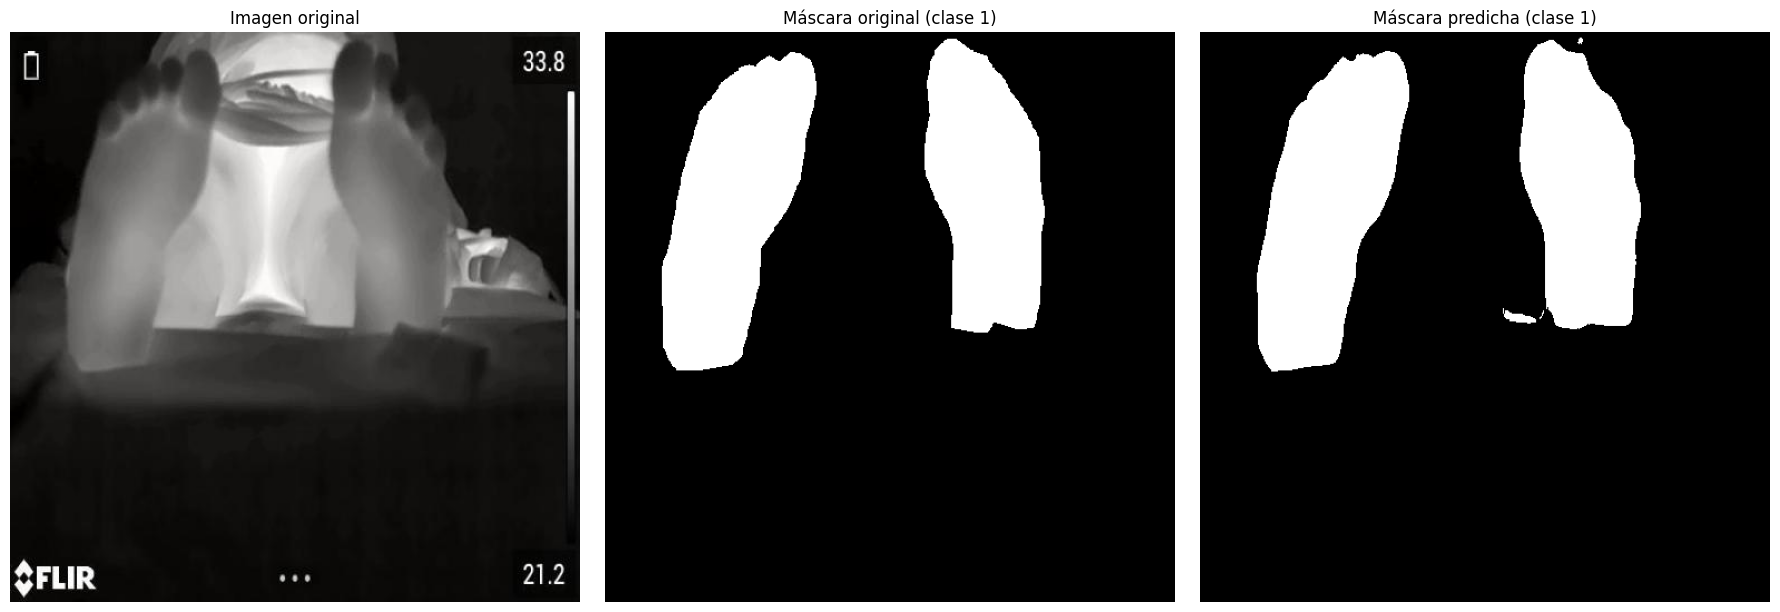

In [21]:
## Obtenemos un batch del dataset
for images, masks in test_dataset.take(1):
    batch_images = images.numpy()
    batch_masks = masks.numpy()
    print("Shape de imágenes:", batch_images.shape)
    print("Shape de máscaras:", batch_masks.shape)
    
# Elegir una imagen aleatoria del batch
sample_index = random.randint(0, batch_images.shape[0]-1)
input_data = np.expand_dims(batch_images[sample_index], axis=0).astype(np.float32)

# Realizar la predicción
predictions = predict_tflite(interpreter, input_data)

# Visualizar la imagen, máscara original y la predicha
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(batch_images[sample_index])
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1, 3, 2)
# Muestra la máscara original para una de las clases, por ejemplo la clase 1
plt.imshow(batch_masks[sample_index, :, :, 1], cmap='gray')
plt.title("Máscara original (clase 1)")
plt.axis('off')

plt.subplot(1, 3, 3)
# Aplica un umbral a la predicción (0.5 es común, pero puedes ajustarlo)
pred_mask = (predictions[0, :, :, 1] > 0.5).astype(np.float32)
plt.imshow(pred_mask, cmap='gray')
plt.title("Máscara predicha (clase 1)")
plt.axis('off')

plt.tight_layout()
plt.show()

##### **Hacer inferencia mediante dirección de una imagen**

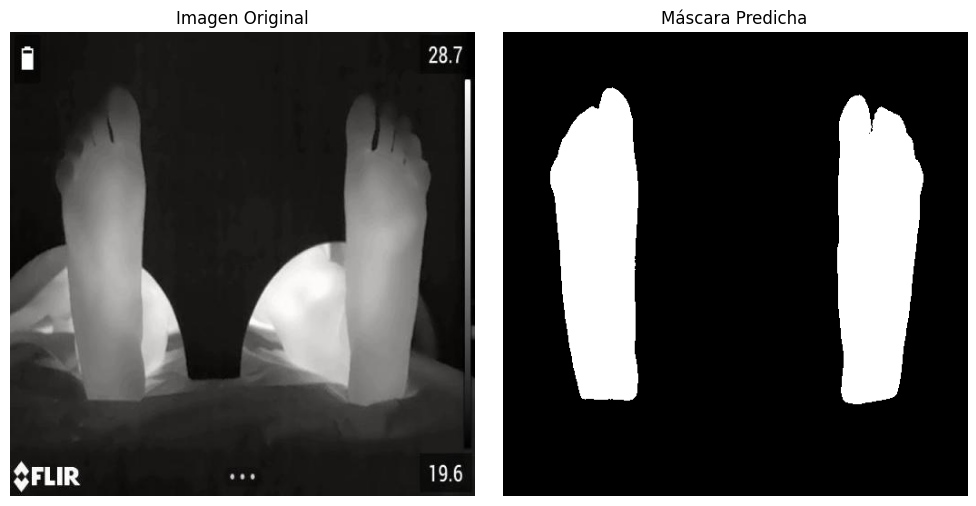

In [27]:
# Ruta de la imagen específica
image_path = '/kaggle/input/mamitas-only-subject/Test/images/t0_caso22_jpg.rf.b0bb88b5c5edec6da4aa60c929085590.png'
raw_image = tf.io.read_file(image_path)
img = tf.image.decode_png(raw_image, channels=3)
img = tf.image.resize(img, [512, 512])
img = tf.cast(img, tf.float32) / 255.0
input_image = np.expand_dims(img.numpy(), axis=0).astype(np.float32)

# Realizar la predicción
prediction = predict_tflite(interpreter, input_image)

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('Imagen Original')
axs[0].axis('off')
axs[1].imshow((prediction[0, :, :, 1] > 0.5).astype(np.float32), cmap='gray')
axs[1].set_title('Máscara Predicha')
axs[1].axis('off')
plt.tight_layout()
plt.show()
